In [1]:
!pip install pynvml==11.4.1
!pip install fastai==2.7.9
!pip install fastkaggle==0.0.7
!pip install fasterai==0.1.11
!pip install ipython-autotime==0.3.1
!pip install pytorch_memlab==0.2.4
!pip install torchview
!pip install torchviz
%load_ext autotime

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: pynvml
    Found existing installation: pynvml 11.5.0
    Uninstalling pynvml-11.5.0:
      Successfully uninstalled pynvml-11.5.0
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.11
    Uninstalling fastai-2.7.11:
      Successfully uninstalled fastai-2.7.11
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6

In [5]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *

from fasterai.sparse.all import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from fastkaggle import *

from fasterai.core.criteria import *
from fasterai.regularize.all import *

from fairscale.experimental.tooling.layer_memory_tracker import LayerwiseMemoryTracker

import torchvision
from torchview import draw_graph
import graphviz

from test_roc_prc import ROC, PRC
import gc

import inspect

from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from fastai.fp16_utils import *
import tensorflow as tf
import pickle as pkl

set_seed(42)

time: 10.4 s (started: 2023-04-19 20:19:25 +00:00)


In [8]:
@patch
def custom_plot_losses(self: Recorder, skip_start=5, with_valid=True, filename="temp.txt"):
    fig2 = plt.figure("Figure 2")

    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_loss') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train loss')
    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_loss') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid loss')
        plt.legend()

    
@patch
def custom_plot_values(self: Recorder, skip_start=5, with_valid=True):
    fig3 = plt.figure("Figure 3")
    
    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_accuracy') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train accuracy')

    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_accuracy') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid accuracy')
        plt.legend()

time: 2.63 ms (started: 2023-04-19 20:19:35 +00:00)


In [9]:
comp = 'paddy-diseases/paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 10.9 s (started: 2023-04-19 20:19:35 +00:00)


In [10]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32)

time: 9.84 s (started: 2023-04-19 20:19:46 +00:00)


In [11]:
sp_cb=[
#       GradientAccumulation(32), 
#       SparsifyCallback(sparsity=25, 
#                          granularity='filter', 
#                          context='local', 
#                          criteria=large_final, 
#                          schedule=one_cycle),


]

time: 914 µs (started: 2023-04-19 20:19:56 +00:00)


In [12]:
model = vgg16_bn(num_classes=10)


time: 2.04 s (started: 2023-04-19 20:19:56 +00:00)


In [13]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy,
                         error_rate,
                        ])
learn.unfreeze()
learn.recorder.train_metrics = True
learn.path = Path("/kaggle/working/")

time: 7.47 ms (started: 2023-04-19 20:19:58 +00:00)


In [17]:
tracker = LayerwiseMemoryTracker()
tracker.monitor(learn.model)

time: 11.4 ms (started: 2023-04-19 20:20:01 +00:00)


In [18]:
learn.fit_one_cycle(1, 3e-5, cbs=sp_cb)

epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,2.150974,0.199519,0.800481,2.018760,0.319231,0.680769,07:19


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


time: 7min 19s (started: 2023-04-19 20:20:01 +00:00)


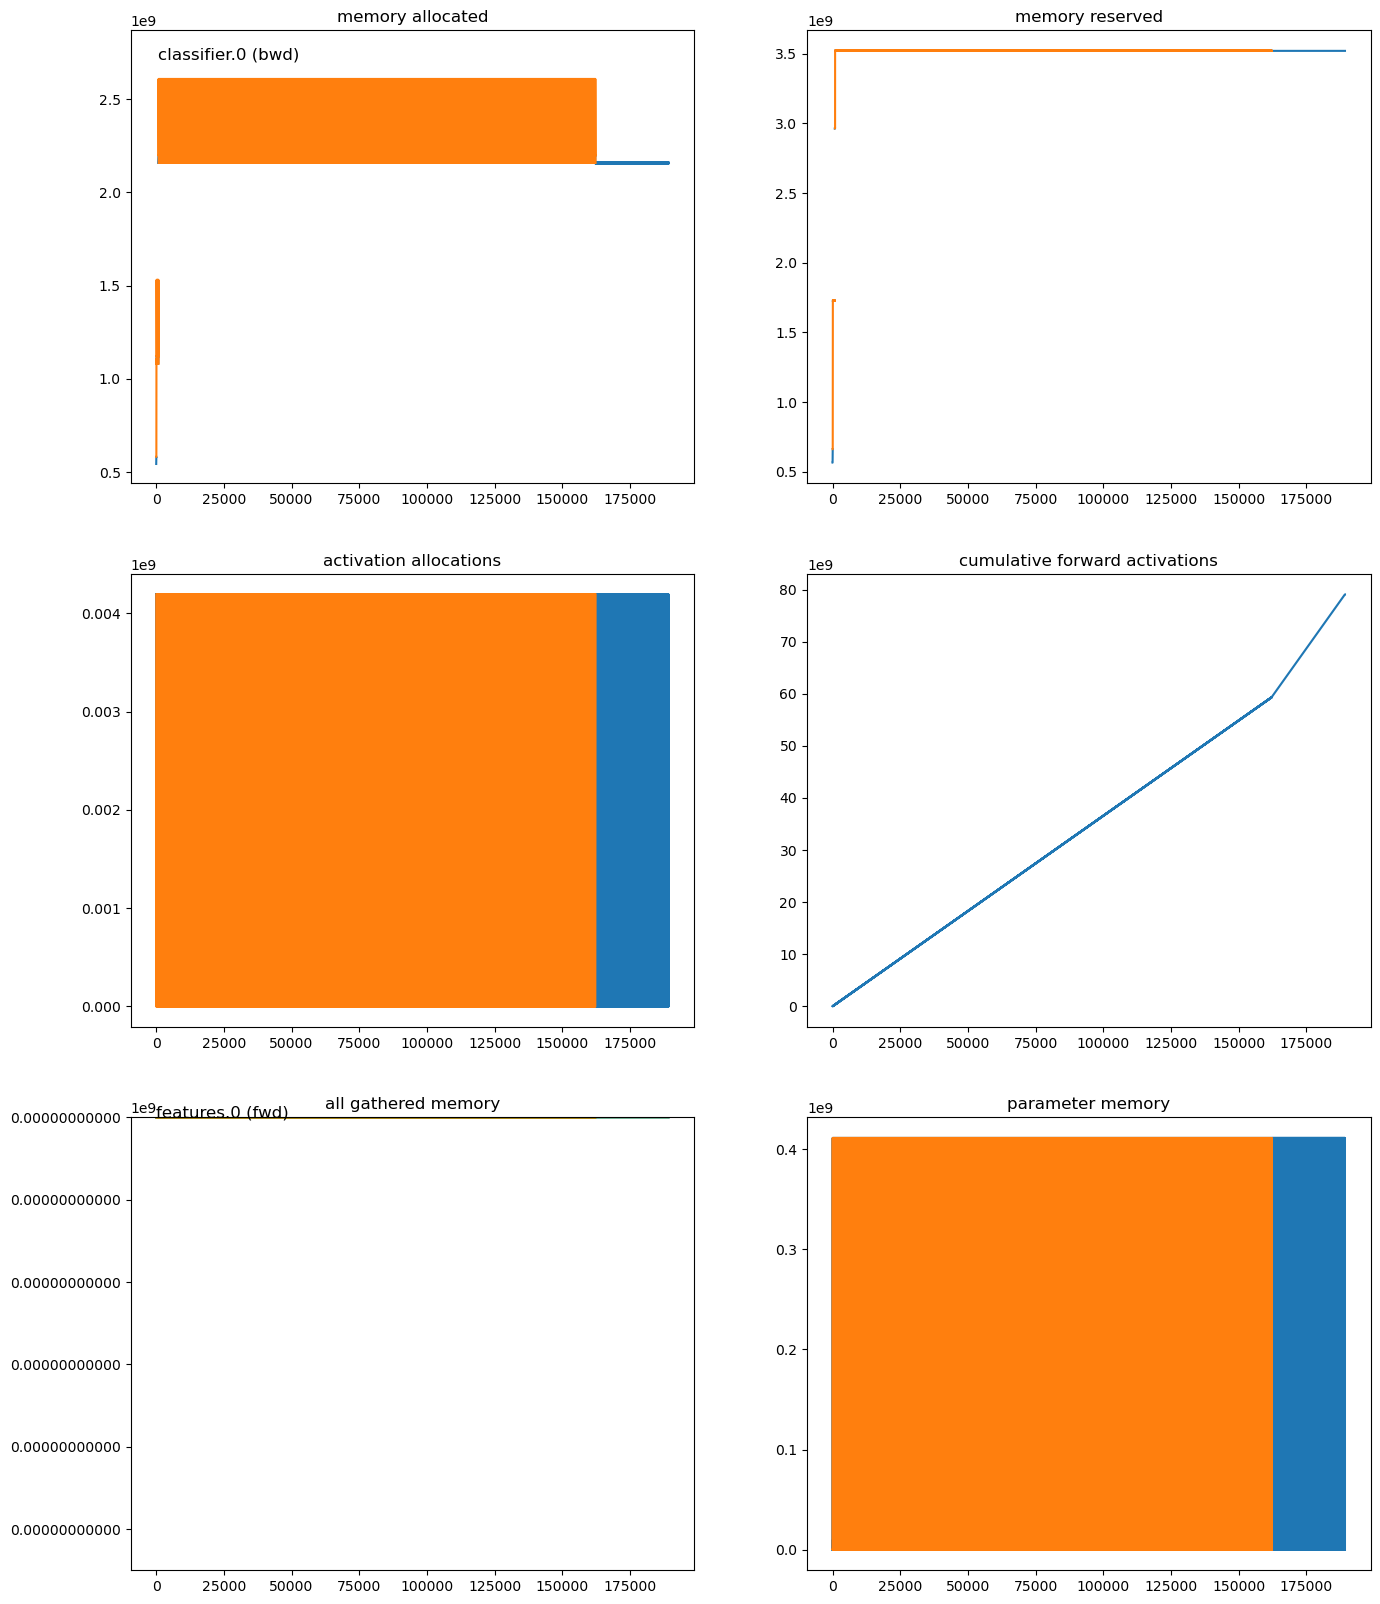

time: 5.14 s (started: 2023-04-19 20:27:20 +00:00)


In [19]:
# # Stop monitoring the model
tracker.stop()

# # Show some useful default plots
tracker.show_plots()

In [25]:
forward_act = sum(t.event.memory_activations for t in tracker.forward_traces[0:52]) 
print(forward_act)

38052000
time: 26.5 ms (started: 2023-04-19 20:27:26 +00:00)


In [26]:
backward_act = sum(t.event.memory_activations for t in tracker.backward_traces[0:52])
print(backward_act)

55877792
time: 24.4 ms (started: 2023-04-19 20:27:26 +00:00)


In [2]:
total_act = forward_act + backward_act
print(f"Activation Memory: {total_act} Byte")

Activation Memory: 93929792 Byte


In [28]:
# Stop monitoring the model
tracker.stop()


time: 587 µs (started: 2023-04-19 20:27:26 +00:00)
